In [251]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os, pprint, pickle, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pp = pprint.PrettyPrinter(indent=2, width=100)
print('Current working dir: ', os.getcwd())
if '..' not in sys.path:
    print("appending '..' to sys.path")
    sys.path.append('..')
import mrcnn.calculate_mean_ap as cmap
    
# import mrcnn.utils     as utils
# import mrcnn.visualize as visualize

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
print(len(class_names))
print(class_names.index('book'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working dir:  E:\git_projs\MRCNN3\notebooks
81
74


In [63]:
def filter_by_class(gt_boxes, pr_boxes, class_id):
    pr_keys_len = len(pr_boxes.keys())
    gt_keys_len = len(gt_boxes.keys())
    assert pr_keys_len == gt_keys_len,  "Number of keys in two input dicts don't match"
#     print(' # pr keys :', pr_keys_len, '# gt_keys: ', gt_keys_len)
    pr_boxes_class = {}
    gt_boxes_class = {}
    
    for key in gt_boxes.keys():
        kk = [ i  for i,j in enumerate(gt_boxes[key]['class_ids']) if j == class_id]
        jj = [ i  for i,j in enumerate(pr_boxes[key]['class_ids']) if j == class_id]
        if (len(kk) == len(jj) == 0 ):
#             print(' Nothing found for this class_id, skip this entry')
            continue
        pr_boxes_class[key] = {"boxes"    : [pr_boxes[key]['boxes'][j]     for j in jj],
                               "class_ids" : [pr_boxes[key]['class_ids'][j] for j in jj],
                               "scores"    : [pr_boxes[key]['scores'][j]    for j in jj] }

        gt_boxes_class[key] = {"boxes"    : [gt_boxes[key]['boxes'][k]     for k in kk],
                               "class_ids" : [gt_boxes[key]['class_ids'][k] for k in kk] }

#         print(key)
#         print('indexes for gt_boxes: ', kk)
#         print('indexes for pr_boxes: ',jj)        
#         print('gt_boxes     : ',[gt_boxes[key]['boxes'][k] for k in kk])
#         print('gt_class_ids : ',[gt_boxes[key]['class_ids'][k] for k in kk])
#         print('pr_boxes     : ',[pr_boxes[key]['boxes'][j] for j in jj])
#         print('pr_scores    : ',[pr_boxes[key]['scores'][j] for j in jj])
#         print('pr_class_ids : ',[pr_boxes[key]['class_ids'][j] for j in jj])
                    
    return gt_boxes_class, pr_boxes_class

In [235]:
def plot_all_pr_curves(all_data, class_id, class_name , ax = None ):
    import time
#     start_time = time.time()
    avg_precs = []
    iou_thrs = []

    for idx, data in enumerate(all_data):
        iou_thr = data['iou']
        avg_precs.append(data['avg_prec'])
        iou_thrs.append(iou_thr)    
        precisions = data['precisions']
        recalls = data['recalls']
        ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)


    # prettify for printing:
    avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
    iou_thrs  = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
    mAP = 100*np.mean(avg_precs)
    ax.set_xlabel('recall', fontsize= 16)
    ax.set_ylabel('precision', fontsize= 16)
    ax.tick_params(axis='both', labelsize = 15)
    ax.set_xlim([0.0,1.1])
    ax.set_ylim([0.0,1.1])
    ax.set_title('Precision-Recall curve for class: {:2d} - {} mAP: {:.2f}'.format(class_id, class_name, mAP), fontsize=18)
    leg = plt.legend(loc='upper right',frameon=True, fontsize = 'xx-small', markerscale = 6)
    leg.set_title('IoU Thr',prop={'size':14})
    for xval in np.linspace(0.0, 1.0, 11):
        plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed', linewidth=2)
#     end_time = time.time()
#     print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
    print('--------------------------------------------')
    print(' class_id : ', class_id, ' - ', class_name)
    print('--------------------------------------------')
    print('avg precs: ', avg_precs)
    print('iou_thrs : ', iou_thrs)
    print('map      : %{:.2f}'.format(mAP))
    print('--------------------------------------------')

In [3]:
path = "F:\PretrainedModels"
# path = "E:\\git_projs\\MRCNN3\\train_coco"
with open(os.path.join(path,"predicted_classes_info.pkl"), 'rb') as infile:
    class_pr_info = pickle.load(infile)        
          
with open(os.path.join(path,"predicted_bboxes.pkl"), 'rb') as infile:
    pr_boxes = pickle.load(infile)
    
with open(os.path.join(path,"ground_truth_bboxes.pkl"), 'rb') as infile:
    gt_boxes = pickle.load(infile)

In [7]:
pr_keys = list(pr_boxes.keys())
gt_keys = list(gt_boxes.keys())

print(len(gt_boxes.keys()), len(pr_boxes.keys()))
print(len(gt_keys), gt_keys[:4])
print(len(pr_keys), pr_keys[:4])


print(' pr key: ',pr_keys[0])
print(pr_boxes[pr_keys[0]]['boxes'])
print(pr_boxes[pr_keys[0]]['scores'])
print(pr_boxes[pr_keys[0]]['class_ids'])
print()
print(' gt key: ',gt_keys[0])
print(gt_boxes[gt_keys[0]]['boxes'])
print(gt_boxes[gt_keys[0]]['class_ids'])

['COCO_val2014_000000555009.jpg', 'COCO_val2014_000000565607.jpg', 'COCO_val2014_000000287874.jpg', 'COCO_val2014_000000131556.jpg', 'COCO_val2014_000000215114.jpg']
 pr key:  COCO_val2014_000000555009.jpg
[[351.0, 0.0, 801.0, 321.0], [128.0, 565.0, 472.0, 979.0], [575.0, 3.0, 731.0, 309.0], [564.0, 353.0, 695.0, 717.0], [363.0, 930.0, 618.0, 1012.0], [135.0, 160.0, 517.0, 535.0], [687.0, 806.0, 800.0, 921.0], [432.0, 779.0, 599.0, 870.0], [418.0, 976.0, 667.0, 1024.0], [592.0, 740.0, 773.0, 901.0], [128.0, 126.0, 602.0, 576.0], [218.0, 96.0, 337.0, 158.0], [673.0, 485.0, 835.0, 663.0], [574.0, 717.0, 843.0, 932.0], [679.0, 195.0, 821.0, 394.0], [610.0, 768.0, 797.0, 907.0]]
[0.9975190162658691, 0.9971610307693481, 0.9971229434013367, 0.9817178249359131, 0.9712333083152771, 0.9442485570907593, 0.9397677779197693, 0.8616337180137634, 0.7269200682640076, 0.6365694403648376, 0.6332679390907288, 0.47912344336509705, 0.3245023787021637, 0.31507471203804016, 0.2923516631126404, 0.29193982481

In [43]:
# for img_id in pred_boxes.keys():
#     arg_sort = np.argsort(pred_boxes[img_id]['scores'])
#     pred_boxes[img_id]['scores'] = np.array(pred_boxes[img_id]['scores'])[arg_sort].tolist()
#     pred_boxes[img_id]['boxes']  = np.array(pred_boxes[img_id]['boxes'])[arg_sort].tolist()

# print(type(class_pr_info), type(pr_boxes))    
# pr_keys = list(gt_boxes.keys())
# print(len(pr_keys))
# pp.pprint(class_pr_info[6].keys())

# class_stats  = {}
# class_stats.setdefault('avg', [cls['avg'] for cls in class_pr_info])
# class_stats.setdefault('pct', [cls['percentiles'] for cls in class_pr_info])   
# pp.pprint(class_stats)

# print(len(pr_keys), pr_keys[0])
# print(pr_boxes[pr_keys[0]])


# print(pred_boxes[pr_keys[0]])
print(len(gt_boxes.keys()))

2416


In [49]:
gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 25)
print(len(pr_boxes_class.keys()), len(gt_boxes_class.keys()))

 # pr keys : 2416 # gt_keys:  2416
COCO_val2014_000000555009.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000565607.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000287874.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000131556.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000215114.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000170474.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000112378.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000523194.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000414034.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000076468.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000280930.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000577539.jpg
 Nothing found for this class_id, skip this entry
COCO_

 Nothing found for this class_id, skip this entry
COCO_val2014_000000232692.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000491213.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000253819.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000308793.jpg
[3]
[2]
gt_boxes     :  [[171, 600, 238, 667]]
gt_class_ids :  [25]
pr_boxes     :  [[213.0, 19.0, 455.0, 308.0]]
pr_scores    :  [0.6862640976905823]
pr_class_ids :  [25]
COCO_val2014_000000280918.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000411530.jpg
[15, 16]
[22, 30, 38]
gt_boxes     :  [[608, 618, 638, 650], [606, 936, 624, 960]]
gt_class_ids :  [25, 25]
pr_boxes     :  [[630.0, 697.0, 720.0, 781.0], [596.0, 717.0, 664.0, 770.0], [606.0, 839.0, 708.0, 902.0]]
pr_scores    :  [0.6716820597648621, 0.5398783087730408, 0.39005109667778015]
pr_class_ids :  [25, 25, 25]
COCO_val2014_000000096001.jpg
 Nothing found for this class_id, skip this en

pr_class_ids :  [25]
COCO_val2014_000000367228.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000326128.jpg
[2]
[2, 3, 6, 10, 14]
gt_boxes     :  [[395, 558, 680, 752]]
gt_class_ids :  [25]
pr_boxes     :  [[392.0, 549.0, 572.0, 710.0], [410.0, 655.0, 568.0, 718.0], [580.0, 523.0, 679.0, 582.0], [803.0, 432.0, 912.0, 503.0], [871.0, 291.0, 947.0, 471.0]]
pr_scores    :  [0.9603827595710754, 0.8869495987892151, 0.6325849294662476, 0.5278182029724121, 0.29172465205192566]
pr_class_ids :  [25, 25, 25, 25, 25]
COCO_val2014_000000343315.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000173371.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000300039.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000080666.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000061471.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000157390.jpg
 Nothing found for this class_id, s

gt_boxes     :  [[498, 566, 546, 603]]
gt_class_ids :  [25]
pr_boxes     :  [[491.0, 563.0, 552.0, 607.0]]
pr_scores    :  [0.953628659248352]
pr_class_ids :  [25]
COCO_val2014_000000146155.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000226417.jpg
[7, 8]
[20, 24, 26, 27, 29, 30, 31, 34, 36, 39]
gt_boxes     :  [[542, 758, 589, 789], [564, 612, 638, 653]]
gt_class_ids :  [25, 25]
pr_boxes     :  [[564.0, 610.0, 640.0, 653.0], [539.0, 650.0, 637.0, 707.0], [539.0, 753.0, 602.0, 790.0], [567.0, 636.0, 629.0, 660.0], [542.0, 443.0, 580.0, 476.0], [532.0, 776.0, 574.0, 798.0], [540.0, 690.0, 596.0, 711.0], [524.0, 408.0, 603.0, 478.0], [580.0, 653.0, 613.0, 700.0], [569.0, 204.0, 596.0, 237.0]]
pr_scores    :  [0.681922972202301, 0.599245011806488, 0.5757471323013306, 0.5653815865516663, 0.5016816854476929, 0.46374693512916565, 0.42779046297073364, 0.4138375222682953, 0.3854093849658966, 0.32980599999427795]
pr_class_ids :  [25, 25, 25, 25, 25, 25, 25, 25, 25, 25]


[]
[13, 17]
gt_boxes     :  []
gt_class_ids :  []
pr_boxes     :  [[360.0, 74.0, 444.0, 125.0], [367.0, 18.0, 469.0, 69.0]]
pr_scores    :  [0.8187606334686279, 0.6849026083946228]
pr_class_ids :  [25, 25]
COCO_val2014_000000407298.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000193926.jpg
[8]
[10]
gt_boxes     :  [[282, 592, 490, 986]]
gt_class_ids :  [25]
pr_boxes     :  [[711.0, 751.0, 854.0, 997.0]]
pr_scores    :  [0.6546759009361267]
pr_class_ids :  [25]
COCO_val2014_000000154004.jpg
[]
[21, 23]
gt_boxes     :  []
gt_class_ids :  []
pr_boxes     :  [[544.0, 321.0, 578.0, 357.0], [342.0, 100.0, 413.0, 197.0]]
pr_scores    :  [0.3598243296146393, 0.3132425844669342]
pr_class_ids :  [25, 25]
COCO_val2014_000000475191.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000263463.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000017899.jpg
 Nothing found for this class_id, skip this entry
COCO_val2014_000000137246.jpg
 

In [249]:
print(gt_boxes['COCO_val2014_000000125572.jpg'])
pp.pprint(pr_boxes['COCO_val2014_000000125572.jpg'])

{'class_ids': [2, 6, 1, 1, 1, 1, 1, 1, 1, 75, 75, 8, 8, 10, 10, 1, 1, 6, 10, 10, 1, 1, 4, 27, 1, 25, 1, 4, -1], 'boxes': [[746, 586, 853, 739], [672, 75, 736, 203], [708, 488, 749, 506], [706, 398, 749, 410], [709, 381, 748, 390], [676, 630, 839, 696], [708, 719, 727, 735], [709, 240, 740, 253], [716, 294, 740, 307], [347, 113, 389, 160], [349, 73, 387, 88], [658, 896, 748, 1024], [680, 856, 741, 915], [632, 253, 682, 267], [669, 488, 692, 507], [703, 203, 759, 217], [708, 137, 762, 165], [682, 25, 733, 77], [676, 509, 690, 517], [669, 341, 692, 358], [708, 406, 748, 418], [708, 211, 759, 243], [719, 786, 746, 813], [752, 687, 781, 731], [712, 706, 743, 715], [714, 494, 732, 504], [708, 445, 751, 456], [725, 352, 741, 376], [703, 33, 768, 867]]}
{ 'boxes': [ [660.0, 890.0, 744.0, 1024.0],
             [344.0, 112.0, 391.0, 155.0],
             [678.0, 622.0, 808.0, 703.0],
             [670.0, 75.0, 742.0, 203.0],
             [701.0, 32.0, 766.0, 55.0],
             [700.0, 137.0, 761

D:\Program Files\Anaconda3\envs\TF\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Program Files\Anaconda3\envs\TF\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


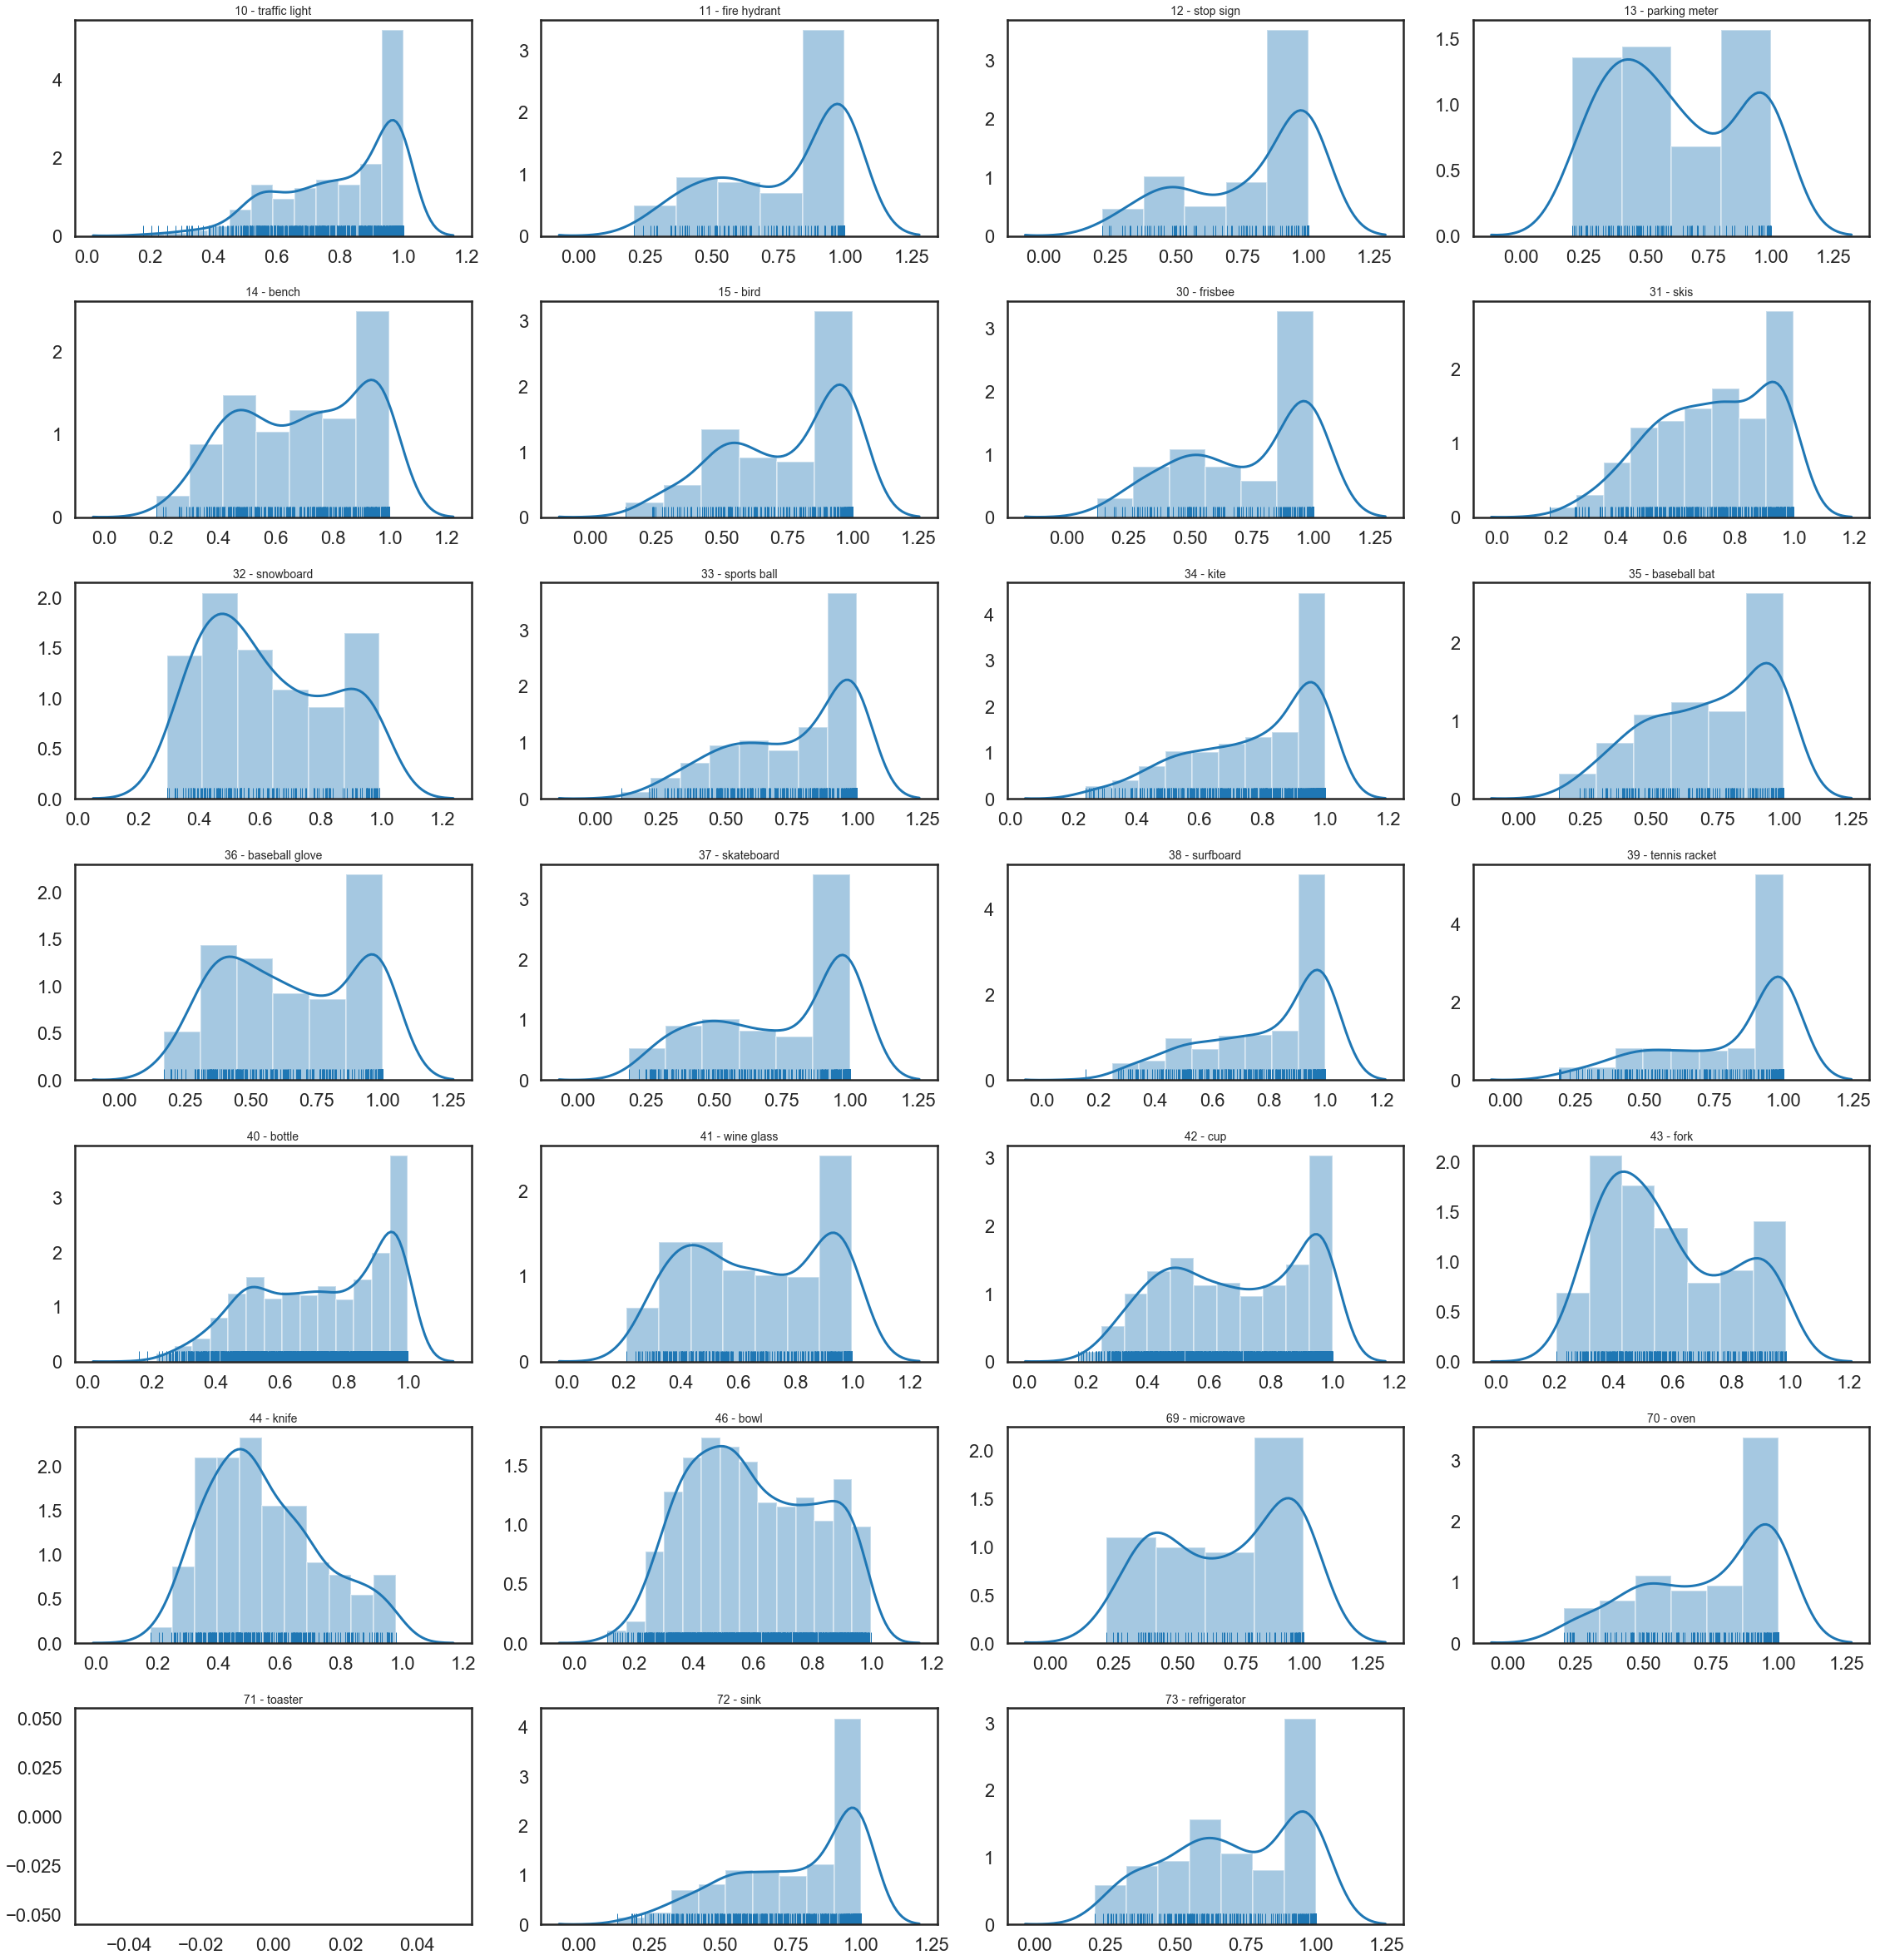

In [248]:
ext_class_ids = [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 10, 11, 13, 14, 15]
class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
num_classes = len(class_ids)

import math 

columns = 4
rows     = math.ceil(num_classes/columns)
fig = plt.figure(figsize=(columns*8, rows * 5))

for idx,cls in enumerate(class_ids):
    row = idx // columns
    col = idx  % columns
    subplot = (row * columns) + col +1
    lbl = "{:2d} - {}".format(cls, class_names[cls])
    ax = fig.add_subplot(rows, columns, subplot)    
    ax.set_title(lbl, fontsize=14)
    x = class_pr_info[cls]['scores']
    sns.distplot(x, ax = ax, rug = True)
fig.tight_layout(rect=[0, 0.02, 1, 0.97])
    

In [125]:
import time
COLORS = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
class_ids     = [10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 69, 70, 71, 72, 73]
# with open('ground_truth_boxes.json') as infile:
# gt_boxes = json.load(infile)

# with open('predicted_boxes.json') as infile:
# pr_boxes= json.load(infile)

# Runs it for one IoU threshold


#### Display mAP for one class and one threshold

Single IoU calculation took 0.0313 secs
avg precision: 0.4959
[0.7]
[0.4959415584415584]
(142,)
(142,)
map: 49.59
avg precs:  [0.4959]
iou_thrs:   [0.7]

Plotting and calculating mAP takes 0.0625 secs


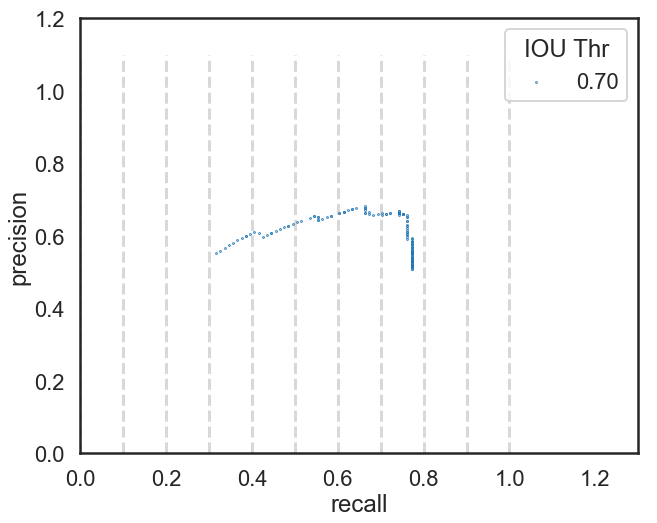

In [126]:
gt_boxes_class, pr_boxes_class = filter_by_class(gt_boxes, pr_boxes, class_id= 11)

iou_thr = 0.7
start_time = time.time()
data = cmap.get_avg_precision_at_iou(gt_boxes_class, pr_boxes_class, iou_thr=iou_thr)
end_time = time.time()
print('Single IoU calculation took {:.4f} secs'.format(end_time - start_time))
print('avg precision: {:.4f}'.format(data['avg_prec']))

idx = 0
ax = None
avg_precs = []
iou_thrs = []
avg_precs.append(data['avg_prec'])
iou_thrs.append(iou_thr)
precisions = data['precisions']
recalls    = data['recalls']
print(iou_thrs)
print(avg_precs)
print(precisions.shape)
print(recalls.shape)
ax = cmap.plot_pr_curve(precisions, recalls, label='{:.2f}'.format(iou_thr), color=COLORS[idx*2], ax=ax)

avg_precs = [float('{:.4f}'.format(ap)) for ap in avg_precs]
iou_thrs = [float('{:.4f}'.format(thr)) for thr in iou_thrs]
print('map: {:.2f}'.format(100*np.mean(avg_precs)))
print('avg precs: ', avg_precs)
print('iou_thrs:  ', iou_thrs)
plt.legend(loc='upper right', title='IOU Thr', frameon=True)
for xval in np.linspace(0.0, 1.0, 11):
    plt.vlines(xval, 0.0, 1.1, color='gray', alpha=0.3, linestyles='dashed')
end_time = time.time()
print('\nPlotting and calculating mAP takes {:.4f} secs'.format(end_time - start_time))
plt.show()

#### Build Average Precision for all class ids we are interested in 
Using loaded gt_boxes and pr_boxes

In [236]:
class_ids     = [10, 11, 12, 13, 14, 
                 15, 30, 31, 32, 33, 
                 34, 35, 36, 37, 38, 
                 39, 40, 41, 42, 43,
                 44, 46, 69, 70, 71, 
                 72, 73]

## build gt_boxes_class, pr_boxes_class which only containing info for each class 
gt_boxes_class = {}
pr_boxes_class = {}

for cls in class_ids :
    print('class id :', cls)
    a, b = filter_by_class(gt_boxes, pr_boxes, class_id= cls)
    gt_boxes_class[cls] = a
    pr_boxes_class[cls] = b
# print(gt_boxes_class.keys())    
# print(pr_boxes_class.keys())    

## build AP info for each class at different thresholds 
all_data = {}
for class_id in class_ids:
    all_class_data = []
    for idx, iou_thr in enumerate(np.linspace(0.5, 0.95, 10)):
        outp = cmap.get_avg_precision_at_iou(gt_boxes_class[class_id], pr_boxes_class[class_id], iou_thr=iou_thr)
        outp['iou'] = iou_thr
        all_class_data.append(outp)
    all_data[class_id] = all_class_data
    

class id : 10
class id : 11
class id : 12
class id : 13
class id : 14
class id : 15
class id : 30
class id : 31
class id : 32
class id : 33
class id : 34
class id : 35
class id : 36
class id : 37
class id : 38
class id : 39
class id : 40
class id : 41
class id : 42
class id : 43
class id : 44
class id : 46
class id : 69
class id : 70
class id : 71
class id : 72
class id : 73
dict_keys([69, 70, 71, 72, 73, 10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46])
dict_keys([69, 70, 71, 72, 73, 10, 11, 12, 13, 14, 15, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46])


--------------------------------------------
 class_id :  10  -  traffic light
--------------------------------------------
avg precs:  [0.37, 0.3367, 0.2773, 0.2017, 0.1744, 0.1013, 0.0398, 0.0106, 0.0026, 0.0005]
iou_thrs :  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map      : %15.15
--------------------------------------------
--------------------------------------------
 class_id :  11  -  fire hydrant
--------------------------------------------
avg precs:  [0.5727, 0.5698, 0.5663, 0.5558, 0.4959, 0.474, 0.3692, 0.1669, 0.0303, 0.0023]
iou_thrs :  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map      : %38.03
--------------------------------------------
--------------------------------------------
 class_id :  12  -  stop sign
--------------------------------------------
avg precs:  [0.4252, 0.4252, 0.4252, 0.4252, 0.4147, 0.3399, 0.2696, 0.1881, 0.1079, 0.0072]
iou_thrs :  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map      : %30.28
---------

--------------------------------------------
 class_id :  72  -  sink
--------------------------------------------
avg precs:  [0.2934, 0.2786, 0.2365, 0.2218, 0.1618, 0.1028, 0.0598, 0.0264, 0.004, 0.0003]
iou_thrs :  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map      : %13.85
--------------------------------------------
--------------------------------------------
 class_id :  73  -  refrigerator
--------------------------------------------
avg precs:  [0.4086, 0.4018, 0.3597, 0.3505, 0.3451, 0.2648, 0.185, 0.0913, 0.0066, 0.0017]
iou_thrs :  [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map      : %24.15
--------------------------------------------


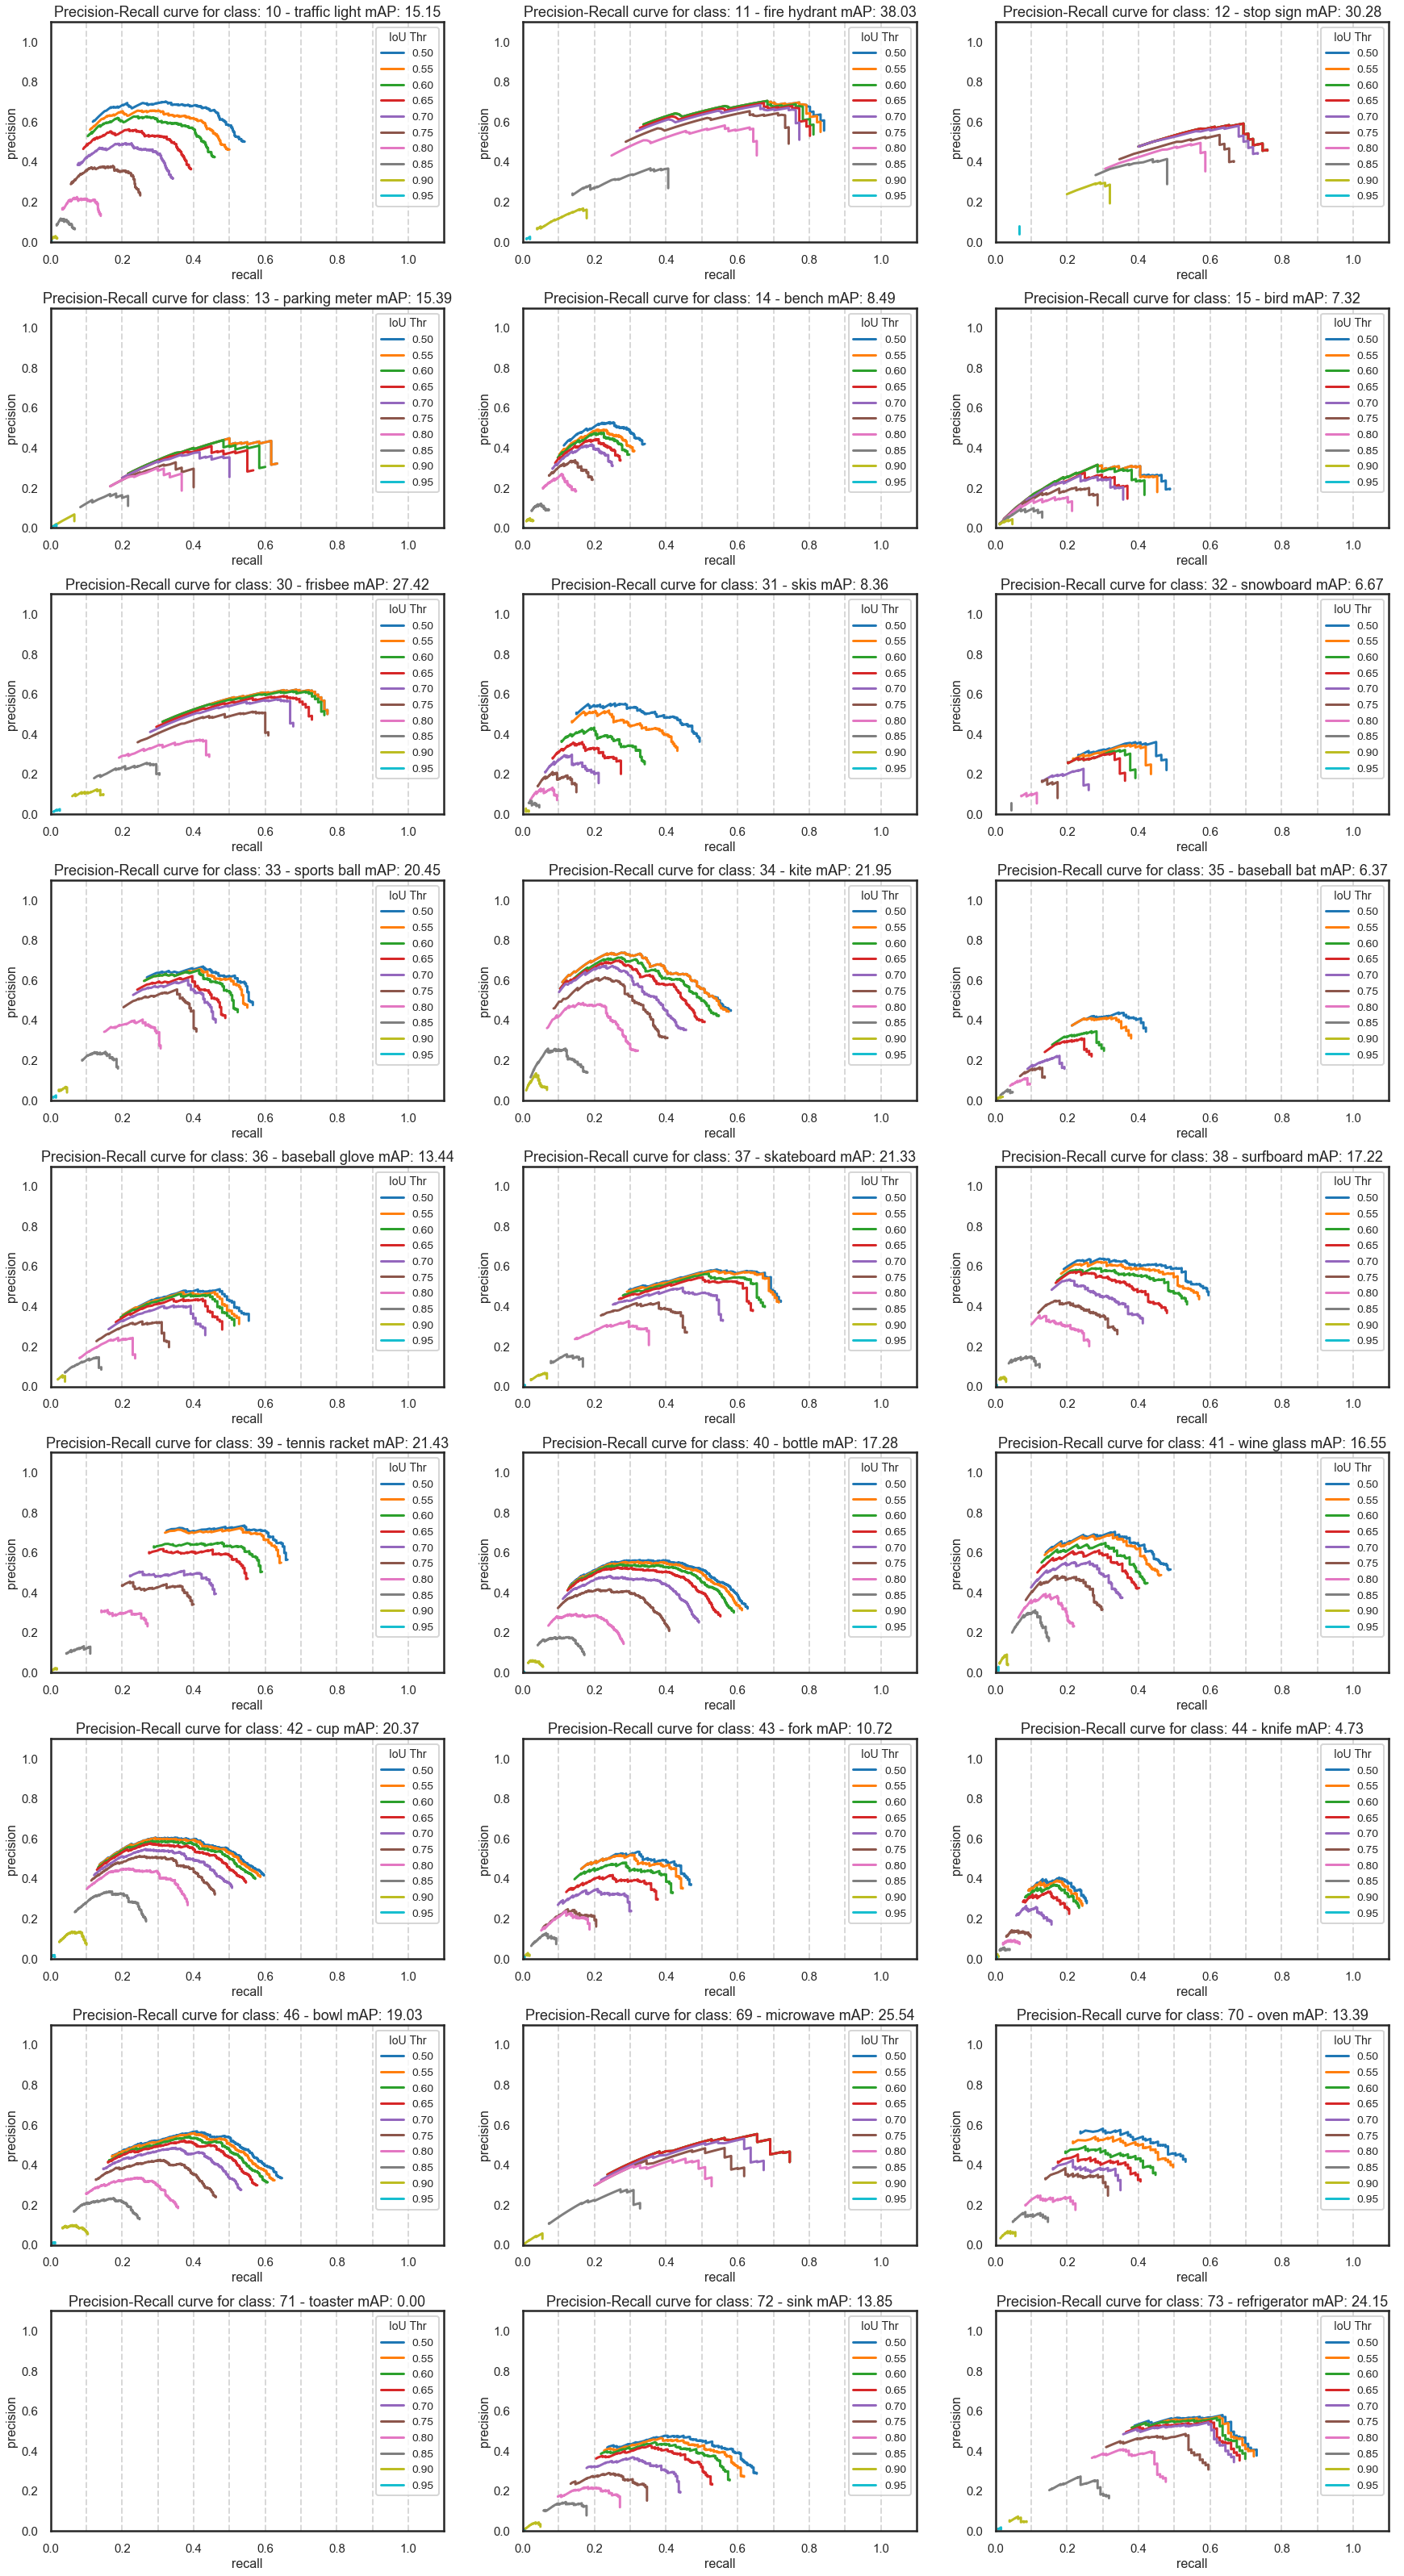

In [242]:
# _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
import math
columns = 3
disp_classes = class_ids ## [36,37,38,39,40,41] #,42]
num_disp_classes = len(disp_classes)
columns = min(columns, num_disp_classes)
rows    = math.ceil(num_disp_classes/columns)

fig = plt.figure(figsize=(8 *columns, 5* rows))


for idx, class_id in enumerate(disp_classes):
    row = idx // columns
    col = idx  % columns
    subplot = (row * columns) + col +1
    
    ax= fig.add_subplot(rows, columns, subplot)
    plot_all_pr_curves(all_data[class_id], class_id, class_names[class_id], ax = ax)    


plt.subplots_adjust(top=0.98, bottom=0.02, left=0.02, right=0.98, hspace=0.30, wspace=0.20)   
plt.show()    

### `get_models_scores_map()`

In [39]:
def get_model_scores_map(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.

    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'

    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)

    """
    model_scores_map = {}
    for img_id, val in pred_boxes.items():
        for raw_score in val['scores']:
            score = round(raw_score,5)
            if score not in model_scores_map.keys():
                model_scores_map[score] = [img_id]
            else:
                model_scores_map[score].append(img_id)
    return model_scores_map

In [42]:
model_scores_map = get_model_scores_map(pr_boxes)
sorted_model_scores = sorted(model_scores_map.keys())
print(type(model_scores_map), type(sorted_model_scores))

<class 'dict'> <class 'list'>


In [56]:
# del test
# print(len(model_scores_map), len(sorted_model_scores))
# pp.pprint(sorted_model_scores[:50])
# pp.pprint(sorted_model_scores[-20:])
pr_keys = list(pr_boxes.keys())
img_id = pr_keys[0]
print(img_id)

COCO_val2014_000000579070.jpg


In [67]:
print(pr_boxes[img_id]['scores'])
arg_sort = np.argsort(pr_boxes[img_id]['scores'])
print(arg_sort)
t1 = np.array(pr_boxes[img_id]['scores'])[arg_sort].tolist()


[0.9989544153213501, 0.9950873255729675, 0.9942910671234131, 0.9939318895339966, 0.9927835464477539, 0.9900364875793457, 0.988672137260437, 0.9878601431846619, 0.9873445630073547, 0.9860664010047913, 0.9840623736381531, 0.979099452495575, 0.9788808822631836, 0.9661685824394226, 0.9590604305267334, 0.9520761966705322, 0.9479620456695557, 0.9465805292129517, 0.9377723336219788, 0.9367051720619202, 0.9344803690910339, 0.9180600047111511, 0.9045032262802124, 0.8705406188964844, 0.8653576970100403, 0.8250425457954407, 0.814799427986145, 0.776642918586731, 0.7752306461334229, 0.7614345550537109, 0.6754932403564453, 0.6709023714065552, 0.6665496230125427, 0.6302854418754578, 0.6251699328422546, 0.5885490775108337, 0.5451349020004272, 0.4975960850715637, 0.49558740854263306, 0.4738931953907013, 0.4698731005191803, 0.44420871138572693, 0.425870805978775, 0.40862569212913513, 0.3005531430244446, 0.2620927691459656]
[45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22
 21 20 1

TypeError: only integer scalar arrays can be converted to a scalar index